# Explore a synthetic dataset with high-tail dependencies

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from empirical_copula import (
    empirical_joint_pmf_details,
    empirical_marginal_pmf,
    independent_pmf,
    joint_counts,
    order_pmf,
)
from empirical_copula.plot import (
    copula_pcolormesh,
    significance_copula_pcolormesh,
)
from empirical_copula.significance import significance_from_bootstrap

# Create the dataset

We create two discrete random variables `v1` and `v2`, and assign a probability for observing each pair of values.

The probabilities are defined such that low values for both variables are more frequent, but not strongly dependent, while high values are less frequent but strongly dependent.

In [14]:
random_state = np.random.RandomState(4871)

# generate two correlated time series
values1 = list('ABCDEF')  # Categorical
values2 = [1, 2, 3, 4]  # Ordinal

# All the possible combinations
pairs = np.array([(v1, v2) for v1 in values1 for v2 in values2], dtype=[('v1', object), ('v2', object)])

# # Assign tail-dependent probabilities to each pair
pairs_prob = np.ones(shape=len(pairs)) / len(pairs)
pairs_prob[(pairs['v1'] <= 'C') & (pairs['v2'] <= 2)] = 8.0
for i1, i2 in [('D', 3), ('E', 3), ('F', 4)]:
   pairs_prob[(pairs['v1'] == i1) & (pairs['v2'] == i2)] = 2.0

pairs_prob /= pairs_prob.sum()


Observe samples from this joint distribution

In [16]:
# Create random series
n = 10000
samples = pd.DataFrame(random_state.choice(np.array(pairs), p=pairs_prob, size=(n,)))

# Compute the marginal and joint distribution

In [17]:
pmf1, pmf2, empirical_pmf, others = empirical_joint_pmf_details(samples)
pmf1 = order_pmf(pmf1, is_ordinal=True)
pmf2 = order_pmf(pmf2, is_ordinal=True)

Plotting the empirical joint distribution as a heatmap, one might imagine a strong dependency between low values of `v1` and `v2`

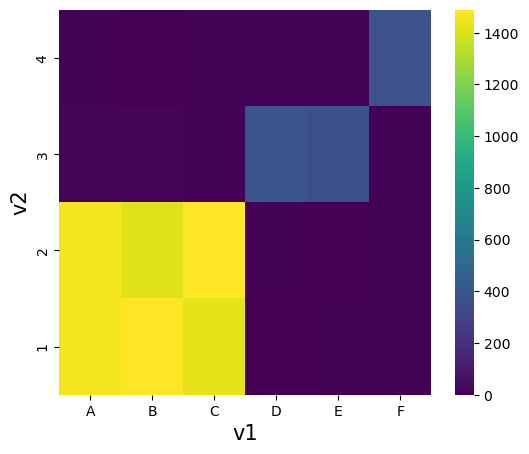

In [18]:
with plt.rc_context({'figure.figsize': (6, 5)}):
    ax = sns.heatmap(others['counts'].loc[pmf1.index, pmf2.index].T, cmap='viridis', vmin=0)
    ax.invert_yaxis()
    plt.xlabel('v1', fontsize=15)
    plt.ylabel('v2', fontsize=15)

However, comparing with the joint distribution expected if the two variables were independent, we see that those values are independently very likely to be observed.

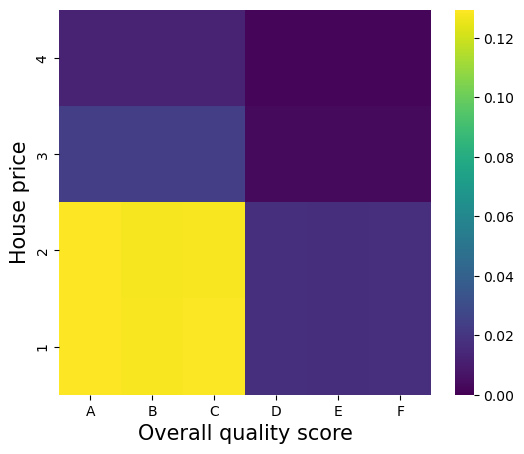

In [19]:
# Expected joint pmf if the two variables were independent
with plt.rc_context({'figure.figsize': (6, 5)}):
    ax = sns.heatmap(others['ind_pmf'].loc[pmf1.index, pmf2.index].T, cmap='viridis', vmin=0)
    ax.invert_yaxis()
    plt.xlabel('Overall quality score', fontsize=15)
    plt.ylabel('House price', fontsize=15)


# Visualize the empirical copula

Independent variables would have an empirical copula with a uniform value of 1.0 . 

We visualize the log10 of the observed copula values. The interpretation of this number is the log of the factor with which a given combination of values is observed compared to the expectation under the hypothesis of independence. For instance, a value of 0.5 in the plot below means that that combination of values appears 10^0.5 = 3.2 times more often than expected if the variables were independent.

In [20]:
diff_from_uniform = np.log10(empirical_pmf.replace(0, 1))

The empirical copula visualized below confirms that there are strong dependencies between the two variables, but only in the high tails of the distribution.

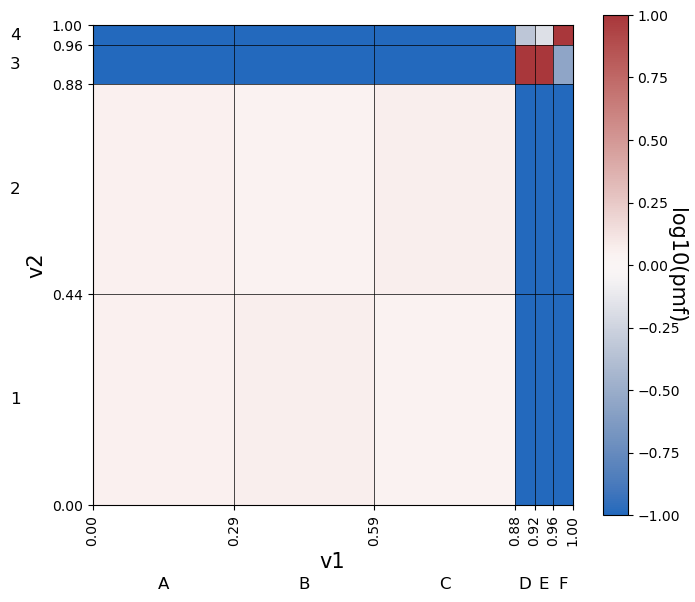

In [21]:
grid_lw = 0.5
max_diff_color = 1

with plt.rc_context({'figure.figsize': (6, 5)}):
    fig = plt.gcf()
    ax, pcm = copula_pcolormesh(fig, pmf1, pmf2, diff_from_uniform, grid_lw=grid_lw, 
                                vmin=-max_diff_color, vmax=max_diff_color, cmap='vlag', annotation_fontsize=12)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('log10(pmf)', fontsize=15, rotation=270)
    plt.xlabel('v1', fontsize=15)
    plt.ylabel('v2', fontsize=15)

# Which of the observed deviations from independence are significant?

Are the strong dependencies observed in the tail statistically significant, or are they just noise due to the small sample site for those combination of values?

We can destroy the dependencies between the variables by resampling them replacement independently from each other. Doing this many times gives us an estimate of the distribution of the frequencies we would observe with the same marginal distribution if the variables were independent. We can then look at how extreme what we observe is compared to this 0-hypothesis distribution and derive a significance level.

In [22]:
random_state = np.random.RandomState(9393)
quantile_levels, quantile_levels_labels, significance = significance_from_bootstrap(
    samples, n_bootstraps=1000, p_levels_low=[0.001, 0.01, 0.05, 0.1], random_state=random_state)

The significance plot confirms that the observed dependencies are highly significant.

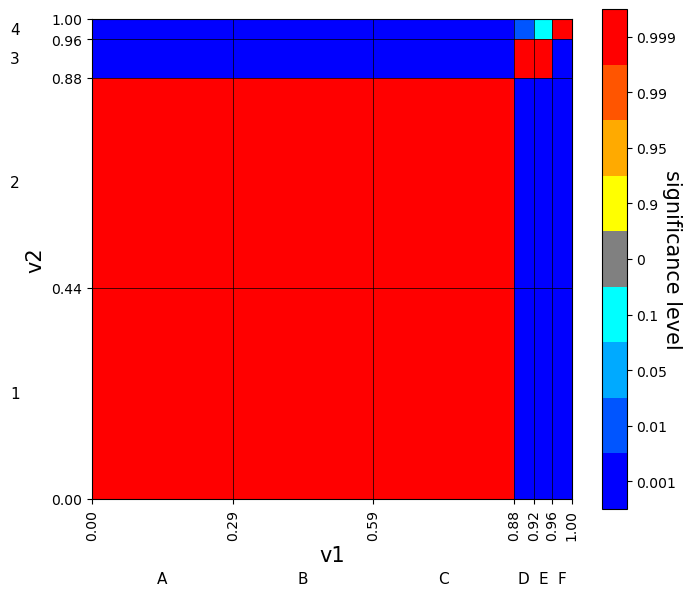

In [27]:
with plt.rc_context({'figure.figsize': (6, 5)}):
    fig = plt.gcf()
    significance_copula_pcolormesh(fig, pmf1, pmf2, significance, quantile_levels, grid_lw=grid_lw, annotation_fontsize=11)
    plt.xlabel('v1', fontsize=15)
    plt.ylabel('v2', fontsize=15)